In [42]:
from pathlib import Path
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, substring
import pyspark.sql.functions as sf
from pyspark.sql.types import StringType, IntegerType, BooleanType, FloatType, TimestampType

DATA_DIR = Path("data/ml-latest-small")
#DATA_DIR = Path("data/ml-latest")

In [17]:
spark = SparkSession.builder\
    .master("local")\
    .appName("Word Count")\
    .getOrCreate()

In [18]:
# TODO: Spark schemas?
def read_df(file: str, types: dict):
    df = spark.read\
        .format("csv")\
        .option("header", "true")\
        .load(str(DATA_DIR / file))
    return set_dtypes(df, types)

def set_dtypes(df, types: dict):
    for column, dtype in types.items():
        dtype = {
            str: StringType(),
            int: IntegerType(),
            float: FloatType(),
            bool: BooleanType(),
            "time": TimestampType() 
        }[dtype]
        df = df.withColumn(column, col(column).cast(dtype))
    return df

df_links = read_df("links.csv", {
    "movieId": int,
    "imdbId": int,
    "tmdbId": int
})
df_movies = read_df("movies.csv", {
    "movieId": int,
    "title": str,
    "genres": str
})
df_ratings = read_df("ratings.csv", {
    "userId": int,
    "movieId": int,
    "rating": float,
    "timestamp": "time"
})
df_tags = read_df("tags.csv", {
    "userId": int,
    "movieId": int,
    "tag": str,
    "timestamp": "time"
})

In [44]:
# Given a user, get the number of movies watched per genre
def search_user(user_id: int):
    rated_movies = df_ratings.filter(df_ratings.userId == user_id).select("movieId").distinct()
    tagged_movies = df_tags.filter(df_tags.userId == user_id).select("movieId").distinct()
    movies = rated_movies.union(tagged_movies).distinct().join(df_movies, on=["movieId"], how="inner")
    movies = movies.select(movies.movieId, explode(split(movies.genres, "\|")).alias("genre"))
    movies = movies.groupBy("genre").count()
    return movies
#search_user(1)

In [20]:
df_ratings.filter("userId = 21").filter("movieId=1").collect()

[Row(userId=21, movieId=1, rating=3.5, timestamp=None)]

In [21]:
# Given a list of users, search all movies watched by each user
def search_movies_by_users(user_ids: [int]):
    rated_movies = df_ratings.filter(df_ratings.userId.isin(user_ids))
    tagged_movies = df_tags.filter(df_tags.userId.isin(user_ids))
    movies = rated_movies.join(tagged_movies, on=["userId", "movieId"], how="outer")
    movies = movies.select("userId", "movieId").distinct()
    movies = movies.groupBy("movieId").count().join(df_movies, on=["movieId"]).select("title", "count")
    return movies.collect()
#search_movies_by_users([1, 21])

In [22]:
# Search movie by id/title, show the average rating, the number of users that have watched the movie
# TODO: Need to translate between ID & Title
def search_movies_watched_by_id(movie_id: int):
    rated_movies = df_ratings.where(f"movieId = {movie_id}")
    tagged_movies = df_tags.where(f"movieId = {movie_id}")
    movies = rated_movies.join(tagged_movies, on=["userId"], how="outer")
    movies = movies.select("userId").distinct()
    return movies.count()
#search_movies_watched_by_id(1) # Toy Story

In [23]:
# Search movie by id/title, show the average rating, the number of users that have watched the movie
def search_movies_avg_rating_by_id(movie_id: int):
    rated_movies = df_ratings.where(f"movieId = {movie_id}").agg({"rating": "avg"})
    return rated_movies.first()[0]
#search_movies_avg_rating_by_id(1) # Toy Story

In [24]:
# Given a list of genres, search all movies belonging each genre
def search_movies_by_genre(genres: [str]):
    movies = df_movies.select("movieId", "title", explode(split(df_movies.genres, "\|")).alias("genre"))
    movies = movies.filter(movies.genre.isin(genres)).dropDuplicates(subset=["movieId"])
    return [row.title for row in movies.select("title").collect()]
#search_movies_by_genre(["Action", "Crime"])

In [25]:
# Search movies by year
def search_movies_by_year(year: int):
    movies = df_movies.select("movieId", "title", substring(df_movies.title, -5, 4).cast(IntegerType()).alias("year"))
    movies = movies.filter(movies.year == year)
    return movies.collect()
#search_movies_by_year(1979)

In [26]:
# List the top n movies with highest rating, ordered by the rating
def top_n_movies_by_rating(n: int):
    top_n = df_ratings.groupBy("movieId")\
        .agg(sf.avg("rating").alias("rating"), sf.count("movieId").alias("count"))\
        .join(df_movies, on=["movieId"], how="inner")\
        .sort(col("rating").desc(), col("count").desc())\
        .limit(n)
    return top_n.collect()
#top_n_movies_by_rating(10)

In [27]:
# List the top n movies with the highest number of watches, ordered by the number of watches
# INFO: watch count for one movie is total number of people who rated or tagged the movie at least once
def top_n_movies_by_watch_count(n: int):
    movies = df_ratings.join(df_tags, on=["userId", "movieId"], how="outer")\
                .select("userId", "movieId").distinct()\
                .groupBy("movieId").count().join(df_movies, on=["movieId"])\
                .sort(col("count").desc())\
                .limit(n)
    return movies.collect()
#top_n_movies_by_watch_count(10)

In [37]:
# Find the favourite genre of a given user, or group of users. Consider and justify how you will define ‘favourite’.
# NOTE: we define "favourite" as the most frequent genre among all "watched" movies
def favourite_genre(user_ids: [int]):
    rated_movies = df_ratings.filter(df_ratings.userId.isin(user_ids))
    tagged_movies = df_tags.filter(df_tags.userId.isin(user_ids))
    movies = rated_movies.join(tagged_movies, on=["userId", "movieId"], how="outer")
    movies = movies.select("userId", "movieId").distinct()
    movies = movies.groupBy("movieId").count().join(df_movies, on=["movieId"])
    movies = movies.select(movies.movieId, explode(split(movies.genres, "\|")).alias("genre"))\
        .groupBy("genre").count()\
        .sort(col("count").desc())
    return movies.first()["genre"]
favourite_genre([1, 2])

'Action'

<AxesSubplot:xlabel='genre'>

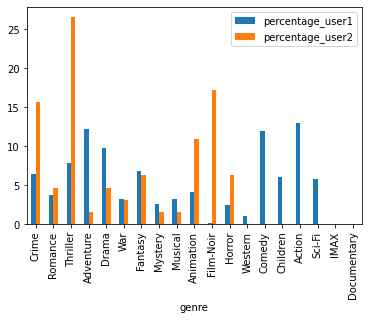

In [85]:
# Compare the movie tastes of two users. Consider and justify how you will compare and present the data.
def normalize_genres(df_genres: pd.DataFrame, genres: set) -> pd.DataFrame:
    for genre in genres - set(df_genres.genre):
        df_genres = df_genres.append({"genre": genre, "count": 0}, ignore_index=True)
    df_genres["percentage"] = df_genres["count"] / df_genres["count"].sum() * 100
    return df_genres

def compare_movie_tastes(user1: int, user2: int):
    user1_genres = search_user(user1).toPandas()
    user2_genres = search_user(user2).toPandas()
    user2_genres = user2_genres.drop(index=[0, 1])
    genres = set(user1_genres.genre).union(user2_genres.genre)
    user1_genres = normalize_genres(user1_genres, genres)
    user2_genres = normalize_genres(user2_genres, genres)
    user1_genres["percentage_user2"] = user2_genres["percentage"]
    user1_genres = user1_genres.rename(columns={"percentage": "percentage_user1"})
    return user1_genres.drop(columns=["count"])
compare_movie_tastes(1, 2).plot.bar("genre", ["percentage_user1", "percentage_user2"])